<a href="https://colab.research.google.com/github/walexi/fellowshipai/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edge-labeling Graph Neural Network for one-shot learning

## Notebook Layout <a id='top'></a>
  * [Imports](#imports)
  * [Data](#data)
    * [Loading](#data-loading)
    *[Exploration](#exploration)
  * [Model](#model)
    * [Architecture and Instantiation](#model-architecture-inst)
  * [Training](#training)
    * [Learning Rate](#training-learning-rate)
    * [Fitting](#training-fitting)
    * [Losses](#training-losses)
    * [Image Cleaning](#training-image-cleaning)
    * [Refitting](#training-refitting)
  * [Testing](#testing)
  
Please note that this notebook is structured such that each cell is meant to be run in sequence from top to bottom.

# Imports <a id='imports'></a>

In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
!git clone https://github.com/walexi/fellowshipai

Cloning into 'fellowshipai'...
remote: Enumerating objects: 185, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 185 (delta 103), reused 137 (delta 58), pack-reused 0
Receiving objects: 100% (185/185), 1.63 MiB | 2.01 MiB/s, done.
Resolving deltas: 100% (103/103), done.


In [0]:
!rm -rf src fellowshipai

In [0]:
!cp -rf fellowshipai/src .

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from src.model import EmbeddingImagenet, GraphNetwork, ConvNet
from src.torchtools import *
from src.dataloader import Loader
from src.learner import Learner
import shutil
import os
import random

# Data <a id='data'></a>

## Loading <a id='data-loading'></a>


In [6]:
train_data = datasets.Omniglot(root='./omniglot_data/', download=True, background=True, transform=None)

Files already downloaded and verified


In [7]:
eval_data = datasets.Omniglot(root='./omniglot_data/', download=True, background=False, transform=None)

Files already downloaded and verified


## Exploration <a id='exploration'></a>

### Explore the background set

In [8]:
len(eval_data)

13180

In [9]:
len(train_data._alphabets), len(eval_data._characters)

(30, 659)

In [10]:
train_data._alphabets

['Tifinagh',
 'Japanese_(hiragana)',
 'Inuktitut_(Canadian_Aboriginal_Syllabics)',
 'Mkhedruli_(Georgian)',
 'Syriac_(Estrangelo)',
 'Korean',
 'Sanskrit',
 'Grantha',
 'Balinese',
 'Japanese_(katakana)',
 'Tagalog',
 'Hebrew',
 'Cyrillic',
 'Greek',
 'Bengali',
 'Arcadian',
 'Burmese_(Myanmar)',
 'Malay_(Jawi_-_Arabic)',
 'Blackfoot_(Canadian_Aboriginal_Syllabics)',
 'Braille',
 'Armenian',
 'Asomtavruli_(Georgian)',
 'N_Ko',
 'Gujarati',
 'Anglo-Saxon_Futhorc',
 'Futurama',
 'Latin',
 'Early_Aramaic',
 'Ojibwe_(Canadian_Aboriginal_Syllabics)',
 'Alphabet_of_the_Magi']

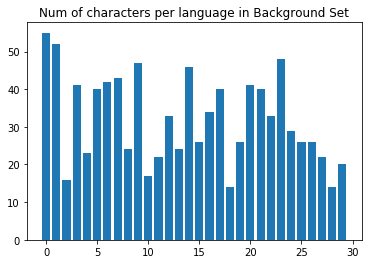

maximum num of characters 55
mean num of characters 32.13
median num of characters 31.0


In [11]:
# background set
per_lang_count = dict()
for a in train_data._alphabets:
    per_lang_count['{}'.format(a)] = len(os.listdir(os.path.join(train_data.target_folder, a)))
plt.bar(range(len(per_lang_count)), list(per_lang_count.values()))
plt.title('Num of characters per language in Background Set')
plt.show()
print('maximum num of characters {}'.format(max(list(per_lang_count.values()))))
print('mean num of characters {:.2f}'.format(np.mean(list(per_lang_count.values()))))
print('median num of characters {}'.format(np.median(list(per_lang_count.values()))))

class: Armenian/character40, img shape: (105, 105)


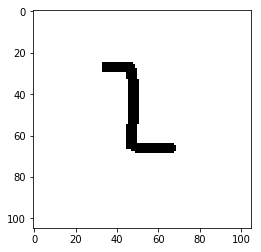

In [12]:
ind = np.random.randint(len(train_data))
img, target = train_data[ind]
class_name = train_data._characters[target]
plt.imshow(np.asarray(img), cmap='gray')
print('class: {}, img shape: {}'.format(class_name, img.size))

### Explore the evaluation set

In [13]:
len(eval_data)

13180

In [14]:
len(eval_data._alphabets), len(eval_data._characters)

(20, 659)

In [15]:
eval_data._alphabets

['Sylheti',
 'Glagolitic',
 'Oriya',
 'Keble',
 'Atemayar_Qelisayer',
 'Tibetan',
 'Kannada',
 'Manipuri',
 'Ge_ez',
 'Tengwar',
 'Atlantean',
 'Syriac_(Serto)',
 'Mongolian',
 'Malayalam',
 'Gurmukhi',
 'Aurek-Besh',
 'Angelic',
 'ULOG',
 'Avesta',
 'Old_Church_Slavonic_(Cyrillic)']

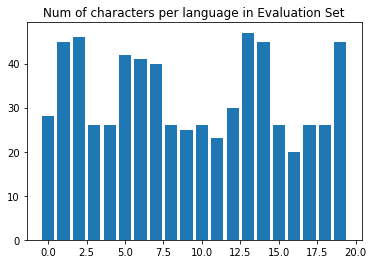

maximum num of characters 47
mean num of characters 32.95
median num of characters 27.0


In [16]:
# evaluation set
eval_per_lang_count = dict()
for a in eval_data._alphabets:
    eval_per_lang_count['{}'.format(a)] = len(os.listdir(os.path.join(eval_data.target_folder, a)))
# num_eval_chars = list(eval_per_lang_count.values())
plt.bar(range(len(eval_per_lang_count)), list(eval_per_lang_count.values()))
plt.title('Num of characters per language in Evaluation Set')
plt.show()
print('maximum num of characters {}'.format(max(list(eval_per_lang_count.values()))))
print('mean num of characters {:.2f}'.format(np.mean(list(eval_per_lang_count.values()))))
print('median num of characters {}'.format(np.median(list(eval_per_lang_count.values()))))

class: Oriya/character45, img shape: (105, 105)


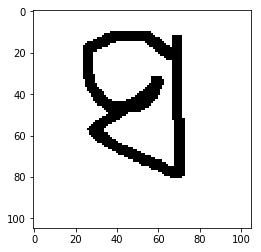

In [17]:
ind = np.random.randint(len(eval_data))
img, target = eval_data[ind]
class_name = eval_data._characters[target]
plt.imshow(np.asarray(img), cmap='gray')
print('class: {}, img shape: {}'.format(class_name, img.size))

# Model <a id='model'></a>

## Parameters <a id="parameter"></a>

In [0]:
tt.arg.device = 'cuda:0' if tt.arg.device is None else tt.arg.device
tt.arg.dataset_root = 'omniglot_data'
tt.arg.num_ways = 20 if tt.arg.num_ways is None else tt.arg.num_ways
tt.arg.num_shots = 1 if tt.arg.num_shots is None else tt.arg.num_shots
tt.arg.num_unlabeled = 0 if tt.arg.num_unlabeled is None else tt.arg.num_unlabeled
tt.arg.num_layers = 3 if tt.arg.num_layers is None else tt.arg.num_layers
tt.arg.meta_batch_size = 40 if tt.arg.meta_batch_size is None else tt.arg.meta_batch_size
tt.arg.transductive = False if tt.arg.transductive is None else tt.arg.transductive
tt.arg.seed = 222 if tt.arg.seed is None else tt.arg.seed
tt.arg.num_gpus = 1 if tt.arg.num_gpus is None else tt.arg.num_gpus

tt.arg.num_ways_train = tt.arg.num_ways
tt.arg.num_ways_test = tt.arg.num_ways

tt.arg.num_shots_train = tt.arg.num_shots
tt.arg.num_shots_test = tt.arg.num_shots

tt.arg.train_transductive = tt.arg.transductive
tt.arg.test_transductive = tt.arg.transductive

### Model Parameters <a id="model_parameter"></a>

In [0]:
tt.arg.num_edge_features = 96
tt.arg.num_node_features = 96
tt.arg.emb_size = 128

### Train/Test Parameters <a id="train_test_parameters"></a>

In [0]:
tt.arg.train_iteration = 100000
tt.arg.test_iteration = 10000
tt.arg.test_interval = 5000
tt.arg.test_batch_size = 10
tt.arg.log_step = 1000

tt.arg.lr = 1e-3
tt.arg.grad_clip = 5
tt.arg.weight_decay = 1e-6
tt.arg.dec_lr = 15000
tt.arg.dropout = 0.1

In [0]:
np.random.seed(tt.arg.seed)
torch.manual_seed(tt.arg.seed)
torch.cuda.manual_seed_all(tt.arg.seed)
random.seed(tt.arg.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

tt.arg.log_dir_user = tt.arg.log_dir
tt.arg.log_dir = tt.arg.log_dir_user

if not os.path.exists('asset/checkpoints'):
   os.makedirs('asset/checkpoints')
if not os.path.exists('asset/checkpoints/run'):
   os.makedirs('asset/checkpoints/run')



In [22]:
train_loader = Loader(root=tt.arg.dataset_root, partition='omniglot-py/images_background')
valid_loader = Loader(root=tt.arg.dataset_root, partition='omniglot-py/images_evaluation')

data_loader = {'train': train_loader, 'val': valid_loader}

    


loading alphabet: Tifinagh
Total number of alphabet: 30
Total number of character sets in Tifinagh is 55
Total number of images in Tifinagh is: 1100
loading alphabet: Japanese_(hiragana)
Total number of alphabet: 30
Total number of character sets in Japanese_(hiragana) is 52
Total number of images in Japanese_(hiragana) is: 1040
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
Total number of alphabet: 30
Total number of character sets in Inuktitut_(Canadian_Aboriginal_Syllabics) is 16
Total number of images in Inuktitut_(Canadian_Aboriginal_Syllabics) is: 320
loading alphabet: Mkhedruli_(Georgian)
Total number of alphabet: 30
Total number of character sets in Mkhedruli_(Georgian) is 41
Total number of images in Mkhedruli_(Georgian) is: 820
loading alphabet: Syriac_(Estrangelo)
Total number of alphabet: 30
Total number of character sets in Syriac_(Estrangelo) is 23
Total number of images in Syriac_(Estrangelo) is: 460
loading alphabet: Korean
Total number of alphabet: 30
Tot

## Architecture & Initialization <a id="initialization"></a>

In [0]:
enc_module = EmbeddingImagenet(emb_size=tt.arg.emb_size)

gnn_module = GraphNetwork(in_features=tt.arg.emb_size,
                            node_features=tt.arg.num_edge_features,
                            edge_features=tt.arg.num_node_features,
                            num_layers=tt.arg.num_layers,
                            dropout=tt.arg.dropout)


# Training <a id='training'></a>

In [24]:
# create trainer
trainer = Learner(enc_module=enc_module,
                         gnn_module=gnn_module,
                         data_loader=data_loader)

trainer.train()

RuntimeError: ignored

## Learning Rate <a id='training-learning-rate'></a>

## Fitting <a id='training-fitting'></a>

## Losses <a id='training-losses'></a>

# Evaluation <a id='evaluation'></a>